In [5]:
import tensorflow as tf
import numpy as np
#from utils import build_model
import pandas as pd
from tqdm import tqdm
import imageio
import matplotlib.pyplot as plt
import keras
from keras.layers import Conv2D, Dropout, Flatten, Dense
from keras.regularizers import l2
import statsmodels.api as sm
from utils import build_model
import glob
import os

In [3]:
checkpoint_path = '../../../../data/models/mc_dropout_cil/export/'

In [7]:
shard_path  = '../../../../data/commaai/training_files/unfiltered_smaller_images_y/'

c = 300000
EPOCHS = 50
STEPS = c*EPOCHS

# read in shards from shard directory
shard_files = glob.glob(os.path.join(shard_path, "*.tfrecords")) 
print('training with ' + str(len(shard_files)) + ' shards.')


training with 2226 shards.


In [4]:
model = build_model()
model.load_weights(tf.train.latest_checkpoint(checkpoint_path))

In [5]:
# all training images and paths
path_all_imgs = '../../../../commaai_code/02_write_shards_optional/cil_shards/df_paths.csv'
all_img_df = pd.read_csv(path_all_imgs)
img_path_base = '../../../../data/commaai/test_files/val_files_unfiltered/'
density_path= '../../../../data/commaai/density/gaussian_density.csv'
density = pd.read_csv(density_path)
all_img_df = all_img_df[np.abs(all_img_df['true_y']) < 40].reset_index()

In [6]:
# extract Bzetas by reading in images and predicting
labels = []
preds = []
for i in tqdm(range(0,all_img_df.shape[0])): 
    img = imageio.imread(str(img_path_base + all_img_df.loc[i,'path']))[:,:,0:3]/255
    pred = model.predict(img.reshape(1,66,200,3))
    label = all_img_df.loc[i,'true_y']
    labels.append(label)       
    preds.append(pred)

# rearrange to arrays
labels = np.array(labels)
preds = np.array(preds)

100%|██████████| 94570/94570 [4:16:02<00:00,  6.16it/s]  


In [7]:
np.save('preds_cil.npy', preds)
np.save('labels_cil.npy', labels)

In [8]:
np.mean((labels - preds.reshape(-1,))**2)

9.443948465880284

In [9]:
np.mean(np.abs((labels - preds.reshape(-1,))))

1.603673619100097

In [10]:
np.mean([(labels - preds.reshape(-1,)) <= 6])

0.9861055302950196

In [11]:
np.mean([(labels - preds.reshape(-1,)) <= 2])

0.8917309929153009

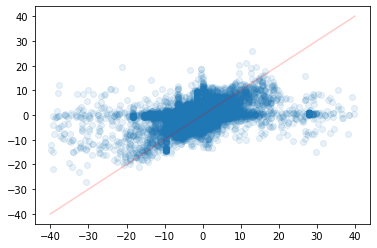

In [12]:
plt.scatter(labels, preds.reshape(-1,), alpha = 0.1)
plt.plot([-40,40], [-40,40], color = 'red', alpha = 0.2)

In [13]:
checkpoint_path = '../../../../data/models/copula_cpl/export/'

## MC-Dropout

In [5]:
#preds_samp = np.load('mc_preds.npy')
preds = np.load('preds_cil.npy')
labels = np.load('labels_cil.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'preds_cil.npy'

In [2]:
preds_1 = np.append(np.load('../../../../data/commaai/predictions/mc_dropout/mc_preds_cil_1.npy'), 
                  np.load('../../../../data/commaai/predictions/mc_dropout/mc_preds_cil_2.npy'), axis = 0)
preds_mc = np.mean(preds_1, axis = 1)

In [3]:
print("Performance of models without and with uncertainty" +
     "\nMSE:" +
      #"\nwithout uncertainty: " + str(np.mean((labels - preds.reshape(10472,))**2)) +
      "\nwith uncertainty: " + str(np.mean((labels - preds_mc.reshape(10472,))**2)) +
      "\nMAE:" +
      #"\nwithout uncertainty: " + str(np.mean(np.abs(labels - preds.reshape(10472,)))) +
      "\nwith uncertainty: " + str(np.mean(np.abs(labels - preds_mc.reshape(10472,)))) +
      "\nAccuracy :" +
      #"\nwithout uncertainty: " + str(np.mean([np.abs((labels - preds.reshape(10472,))) <= 6])) +
      "\nwith uncertainty: " + str(np.mean([np.abs((labels - preds_mc.reshape(10472,))) <= 6])) +
      "\nAccuracy II:" +
      #"\nwithout uncertainty: " + str(np.mean([np.abs((labels - preds.reshape(10472,))) <= 2])) +
      "\nwith uncertainty: " + str(np.mean([(labels - preds_mc.reshape(10472,)) <= 2])) 
     )

NameError: name 'labels' is not defined